This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case. \

In [ ]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import utils, fitter, plot_utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction
import flip
flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

In [2]:
flip.covariance.emulators.gpmatrix.gpy_installed

True

Loading the data, located in the package itself



In [3]:
data_velocity = pd.read_parquet(data_path / "velocity_data.parquet")


data_velocity_true = {**data_velocity.rename(columns={'vpec': 'velocity'}).to_dict(orient='list'), 
                      "velocity_error": np.zeros(len(data_velocity["vpec"].values))}


# Create the data Vector
DataTrueVel = data_vector.DirectVel(data_velocity_true)

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


# Fit true velocity interpolation sigma_u

In the model, there is a sigma_u parameter which can be interpreted to the smoothing of SNIa position due to peculiar velocities. \
To fit simultaneously this parameter, we interpolate the covariance matrix. 

In [4]:
sigmau_list = np.linspace(10.0, 20.0,20)[:, np.newaxis]
covariance_list = []
size_batch=10_000
number_worker=16


for sigu in sigmau_list:
    
    power_spectrum_dict = {"vv": [[ktt, ptt* utils.Du(ktt, sigu)**2]]}

    covariance_list.append(
        DataTrueVel.compute_covariance(
            "carreres23",
            power_spectrum_dict,
            size_batch=size_batch,
            number_worker=number_worker
        )
    )


[ 000007.75 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.53e+00 seconds
[ 000009.41 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.50e+00 seconds
[ 000011.15 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.57e+00 seconds
[ 000012.82 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.51e+00 seconds
[ 000014.52 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.54e+00 seconds
[ 000016.24 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.56e+00 seconds
[ 000017.42 ]: 11-24 15:33  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.03e+00 seconds
[ 000018.61 ]: 11-24 15:33  root            INFO     Covariance matri

In [22]:
square_covariance, emulator_output_variance, emulator_output_non_diagonal = (
        flip.covariance.emulators.generator.prepare_covariance_matrices(
            covariance_list,
            "vv",
            
        )
    )

In [23]:
square_covariance

True

In [24]:
emulator_output_non_diagonal.shape

(1, 20, 1999000)

In [25]:
variance_model, non_diag_model, _, _ = flip.covariance.emulators.gpmatrix.train(
square_covariance,
emulator_output_variance,
emulator_output_non_diagonal,    
sigmau_list,
verbose=True
)

[ 001734.01 ]: 11-24 16:02  GP              INFO     initializing Y
[ 001734.01 ]: 11-24 16:02  GP              INFO     initializing inference method
[ 001734.01 ]: 11-24 16:02  GP              INFO     adding kernel and likelihood as parameters


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   7.517847e+01   1.063595e-01 
    00s08  0014   6.839728e+01   1.159985e+01 
    00s16  0032   5.607828e+01   1.130754e+00 
    00s19  0038   5.540270e+01   2.674056e-04 
    00s37  0084   5.540036e+01   3.000713e-04 

[ 001734.41 ]: 11-24 16:02  GP              INFO     initializing Y



Runtime:     00s37
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



[ 001734.41 ]: 11-24 16:02  GP              INFO     initializing inference method
[ 001734.41 ]: 11-24 16:02  GP              INFO     adding kernel and likelihood as parameters


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s20  0005   9.828655e+07   8.015984e+11 
    23s00  0018   9.773934e+07   6.378227e+07 
    33s81  0027   9.773907e+07   2.468669e+03 
 01m04s09  0052   9.773907e+07   2.835879e+03 
Runtime:  01m04s09
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



In [34]:
p, e = variance_model[0].predict(np.linspace(10, 20, 100)[:, np.newaxis])


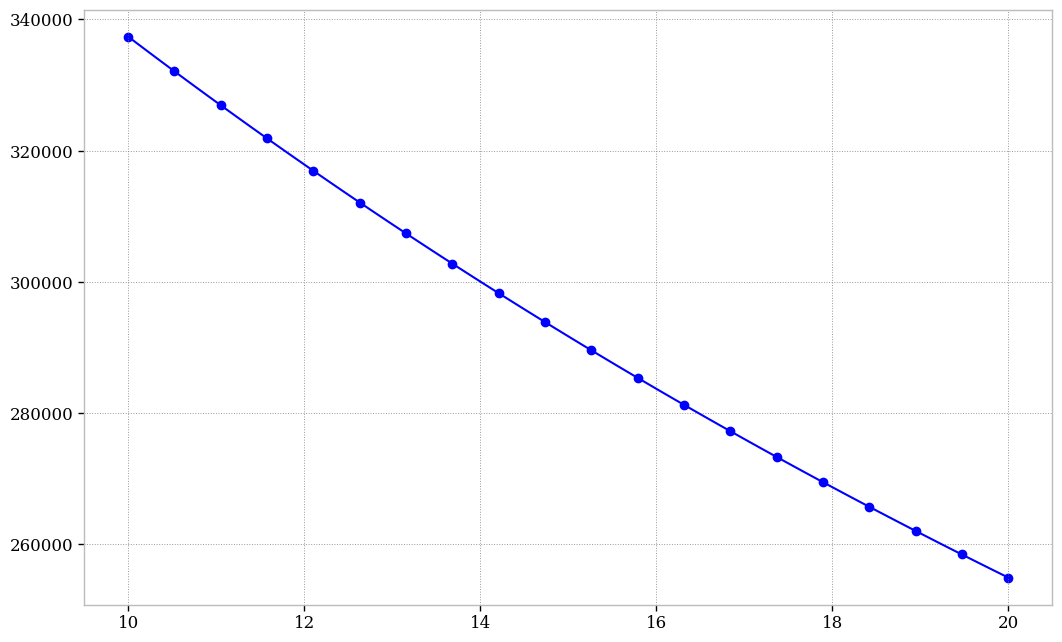

In [38]:
plt.plot(np.linspace(10, 20, 100),p)
pl
plt.scatter(sigmau_list, emulator_output_variance)

In [6]:
emulator_model = "gpmatrix"
emulator_parameter_names = ["sigu"]

covariance_gpmatrix = covariance.CovMatrix.init_from_emulator(
            emulator_model,
            "velocity",
            covariance_list,
            sigmau_list,
            emulator_parameter_names,
            verbose=True,
            test_emulator=False,
        )



[ 000052.97 ]: 11-24 15:34  GP              INFO     initializing Y
[ 000052.98 ]: 11-24 15:34  GP              INFO     initializing inference method
[ 000052.98 ]: 11-24 15:34  GP              INFO     adding kernel and likelihood as parameters


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   5.431875e+07   6.960642e+14 
    00s03  0012   5.410637e+06   4.447962e+11 
    00s06  0020   4.285821e+04   1.026774e+07 
    00s08  0030   3.510244e+02   3.169180e+01 
    00s10  0035   2.277991e+02   3.037298e-03 
    00s11  0039   8.222323e+01   1.279780e-01 
    00s12  0043   2.267220e+02   4.269807e-03 
    00s16  0056   8.454622e+01   2.549128e+01 
    00s17  0058   8.097416e+01   1.371591e-01 
    00s26  0097   8.086316e+01   1.826155e-01 
Runtime:     00s26
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



[ 000053.26 ]: 11-24 15:34  GP              INFO     initializing Y
[ 000053.26 ]: 11-24 15:34  GP              INFO     initializing inference method
[ 000053.26 ]: 11-24 15:34  GP              INFO     adding kernel and likelihood as parameters


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s19  0006   1.546440e+12   1.111035e+24 
Runtime:     05s19
Optimization status: None

KeyboardInterrupt caught, calling on_optimization_end() to round things up



KeyboardInterrupt

 /hpc/group/cosmology/blc56/miniconda3/envs/flip_dev_gpy/lib/python3.12/site-packages/GPy/core/gp.py:286: SyntaxWarning:invalid escape sequence '\m'
 /hpc/group/cosmology/blc56/miniconda3/envs/flip_dev_gpy/lib/python3.12/site-packages/GPy/core/gp.py:299: SyntaxWarning:invalid escape sequence '\i'
 /hpc/group/cosmology/blc56/miniconda3/envs/flip_dev_gpy/lib/python3.12/site-packages/GPy/core/gp.py:705: SyntaxWarning:invalid escape sequence '\m'
 /hpc/group/cosmology/blc56/miniconda3/envs/flip_dev_gpy/lib/python3.12/site-packages/GPy/core/gp.py:721: SyntaxWarning:invalid escape sequence '\m'
 /hpc/group/cosmology/blc56/miniconda3/envs/flip_dev_gpy/lib/python3.12/site-packages/paramz/model.py:127: SyntaxWarning:invalid escape sequence '\*'
 /hpc/group/cosmology/blc56/miniconda3/envs/flip_dev_gpy/lib/python3.12/site-packages/paramz/core/parameter_core.py:302: SyntaxWarning:invalid escape sequence '\d'


In [ ]:
parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigu": {"value": 15.5,
                          "limit_low" : 10.0,
                          "limit_up" : 20.0,
                          "fixed" : False,
                         },
                 }


prior_dict = {"sigu": {"type": "gaussian",
                       "mean" : 15.0,
                       "standard_deviation" : 5.0,},
             }

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "prior": prior_dict}



minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_gpmatrix,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
)

print('Free parameters:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()
